In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [2]:
torch.__version__

'2.4.0'

In [3]:
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
text = open("/kaggle/input/war-and-peace/war_and_peace.txt", mode='r')
lines = text.readlines()
words = pd.Series(lines)
words 

0        "Well, Prince, so Genoa and Lucca are now just...
1        Buonapartes. But I warn you, if you don't tell...
2        if you still try to defend the infamies and ho...
3        Antichrist--I really believe he is Antichrist-...
4        to do with you and you are no longer my friend...
                               ...                        
20376    on the steps in the "reception room"--as Denis...
20377    hut--and it was then so warm that the officers...
20378    always some with Denisov and Rostov, sat in th...
20379                                                   \n
20380                        In April, Rostov was on order
Length: 20381, dtype: object

In [5]:
words = words.str.lower()
words = words.str.strip()
words = words.str.replace("\n", "")
words = words.str.replace('"', '')
words = words.str.replace(',', '')
words = words.str.replace('.', '')
words = words.str.replace('!', '')
words = words.str.replace("'", "")
words = words.str.replace("-", "")
words = words.str.replace("?", "")
words = words.str.replace("(", "")
words = words.str.replace(")", "")
words = words.str.replace(";", "")
words = words.str.replace(":", "")
words = words.str.strip()

In [6]:
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

In [7]:
words[:10]

['',
 'seemed to him that it was a very long time ago almost a day since he',
 'distressed and breathed painfully but could not restrain the wild',
 'and lieutenant telyanin a small officer of the same squadron entered',
 'story to him her seducer and now he a real russian prince had',
 'incessantly pulling and pressing his arm and always dragging it in one',
 '30000 went for the upkeep of the estate near moscow the town house',
 'love him all the more but nicholas now considered himself unworthy of',
 '',
 'not let him and on the other pierre himself feared to begin to speak']

In [8]:
chars = sorted(list(set((" ".join(words)).split(" "))))
stoi = {s:i+2 for i,s in enumerate(chars)}
stoi['.'] = 1
stoi['<S>'] = 0
itos = {i:s for s,i in stoi.items()}
print(len(itos))

11189


In [9]:
block_size = 5 # context length: how many words/characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  # print(w)
  context = [0] * block_size
  for ch in (w.split(" ") + ['<S>']):
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([204978, 5]), torch.int64, torch.Size([204978]), torch.int64)

In [11]:
emb_dim = 32
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.weight

Parameter containing:
tensor([[-1.3567, -0.6809, -0.2665,  ...,  0.7103,  0.3033, -2.4008],
        [ 1.6875,  1.0129,  0.6519,  ..., -0.2320, -0.8125, -0.1128],
        [-2.5260, -0.0505, -0.8715,  ...,  1.4362,  1.0845,  1.5474],
        ...,
        [-1.8958, -0.3828,  1.1208,  ..., -1.2935, -1.0112,  0.8972],
        [-0.7190,  1.4365, -0.5097,  ...,  0.9534,  0.1524, -0.5587],
        [-0.0188, -0.9195,  0.7870,  ..., -1.0307, -0.2304,  0.2068]],
       requires_grad=True)

In [12]:
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size*emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = nn.functional.tanh(self.lin1(x))
        x = self.lin2(x)
        return x 

In [13]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

model = NextChar(block_size, len(stoi), emb_dim, 512).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_words(model, itos, stoi, block_size, max_len=100):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        # print(ix)
        ch = itos[ix]
        if ch == '<S>':
            break
        if ch not in ['"', ',', '.', '!', "'", "-", "?", "(", ")", ";", ":"]:
            name += ' '+ ch
        else:
            name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

W1027 11:49:14.014000 136499258763072 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /tmp/ipykernel_30/2531494610.py line 8 
W1027 11:49:14.014000 136499258763072 torch/_dynamo/convert_frame.py:1009] due to: 
W1027 11:49:14.014000 136499258763072 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1027 11:49:14.014000 136499258763072 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1027 11:49:14.014000 136499258763072 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1027 11:49:14.014000 136499258763072 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1027 11:49:14.014000 136499258763072 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1027 11:49:14.014000 136499258763072 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10

 original lowest breakfast rocky immediately waking bah finest tray heaven rasgulyaythe feast glum distress sumptuous unapproachability pitiful godfather physician regards fruit dams munching jingle manner bitter flood hilt praised say utterance bedouin elegant flurried irritation authorized anxiety exposing shame afterdinner strut disposition wills horrors principles gusto complaining slowly visualized peace mantle yourselves querulous pitt fraud adornment facade imitating fan somewhat insisting luggage fete eyebrows prizes gorchakov comply avail indicate 7 bout vigor unalterably deciding ear forgets be december spitting wet sank appreciation relit lest bolkonskian plants waddling scoundwel penetrating infantrymen excellencys use insisted mist rich served viciously invitations warm halfcut
 exciting gives dispatched cogs jew smoothfelt wary en astonished council conditions atom ambassador opposite amazingly morning affairs frame heelswe adopt oooh uncles forty nurses fire lakes revolu

In [14]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([11189, 32])
_orig_mod.lin1.weight torch.Size([512, 160])
_orig_mod.lin1.bias torch.Size([512])
_orig_mod.lin2.weight torch.Size([11189, 512])
_orig_mod.lin2.bias torch.Size([11189])


In [15]:
len(stoi)

11189

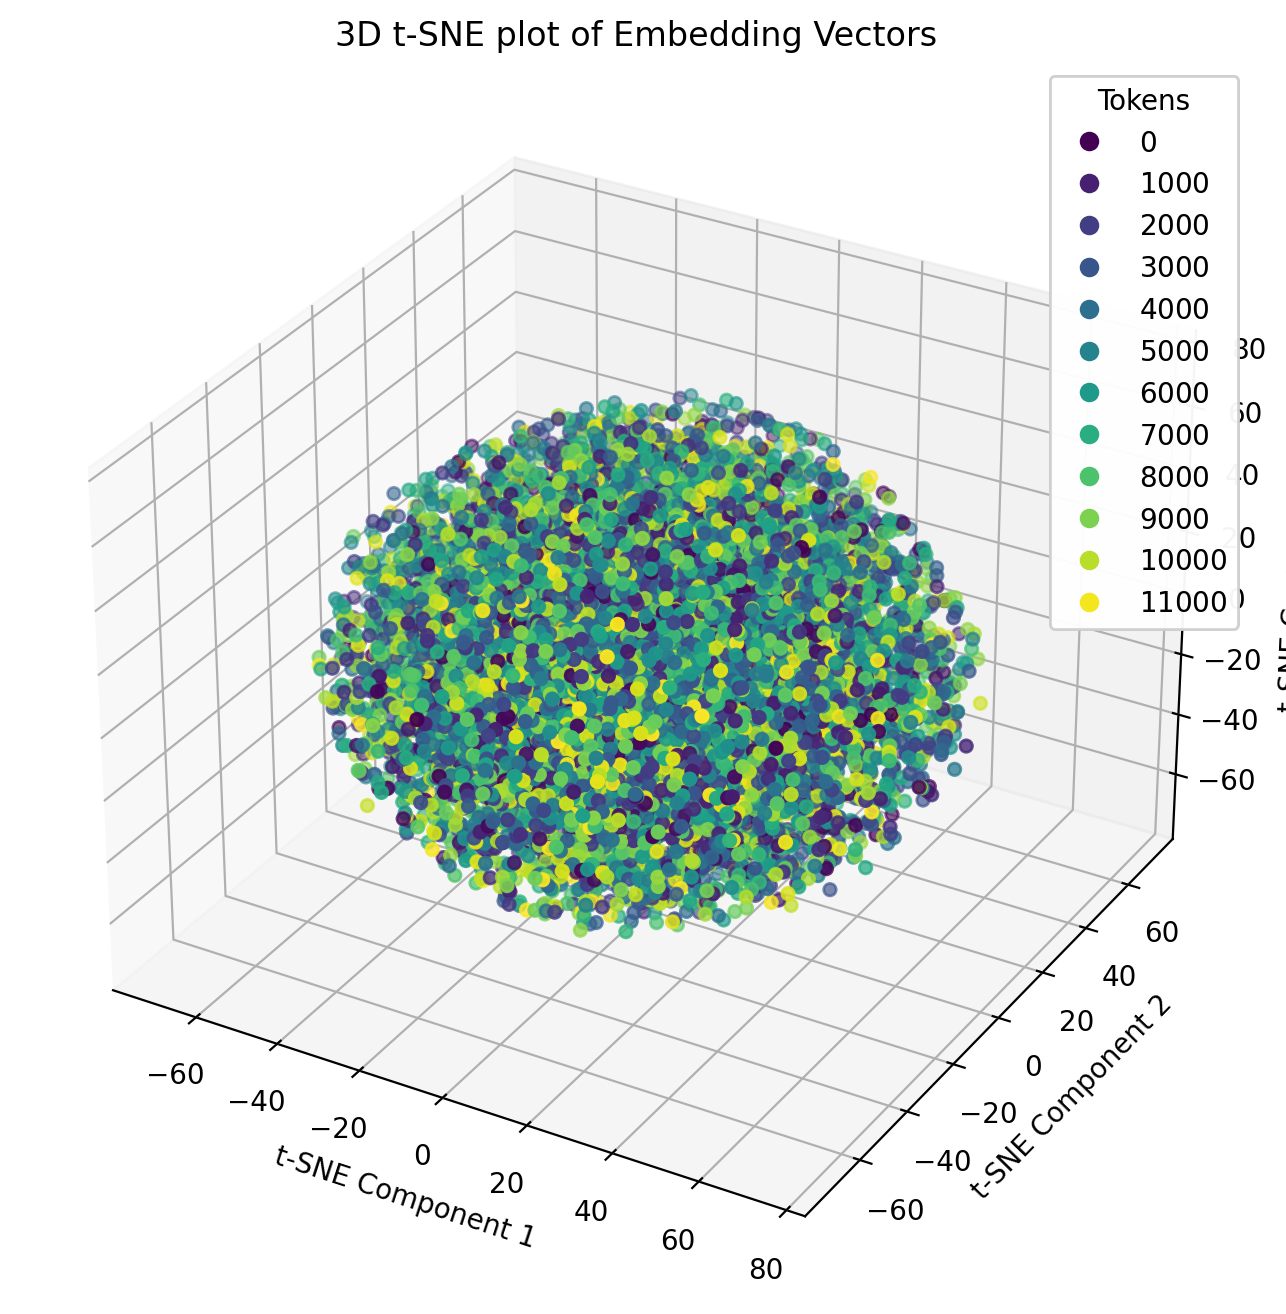

In [16]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

tokens = list(stoi.keys())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()

In [17]:
import time
l1_lambda = 0.000007  # Regularization strength for L1 norm

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.00007)

# Mini-batch training
batch_size = 4000
print_every = 10
elapsed_time = []

for epoch in range(1000):
    start_time = time.time()
    
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        
        try:
            if x.shape[0] != 0:
                # Forward pass
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                loss = loss.to(device)

                # Compute L1 norm (sum of absolute values of weights)
                l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())

                # Add L1 regularization to the loss
                loss += l1_lambda * l1_norm

                # Backward pass
#                 print(y_pred)
#                 print(y)
                loss.backward()
                opt.step()
                opt.zero_grad()
        except:
            pass

    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    try:
        if epoch % print_every == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    except:
        pass


Epoch 0, Loss: 11.84246826171875
Epoch 10, Loss: 8.92269229888916
Epoch 20, Loss: 8.171594619750977
Epoch 30, Loss: 7.702298641204834
Epoch 40, Loss: 7.345453262329102
Epoch 50, Loss: 7.052711009979248
Epoch 60, Loss: 6.801534175872803
Epoch 70, Loss: 6.576202392578125
Epoch 80, Loss: 6.367893695831299
Epoch 90, Loss: 6.172322750091553
Epoch 100, Loss: 5.987250804901123
Epoch 110, Loss: 5.811010837554932
Epoch 120, Loss: 5.642374038696289
Epoch 130, Loss: 5.480608940124512
Epoch 140, Loss: 5.325438976287842
Epoch 150, Loss: 5.176766872406006
Epoch 160, Loss: 5.034573554992676
Epoch 170, Loss: 4.898897171020508
Epoch 180, Loss: 4.769707679748535
Epoch 190, Loss: 4.64697265625
Epoch 200, Loss: 4.5308709144592285
Epoch 210, Loss: 4.421188831329346
Epoch 220, Loss: 4.317784309387207
Epoch 230, Loss: 4.220397472381592
Epoch 240, Loss: 4.128744602203369
Epoch 250, Loss: 4.042379856109619
Epoch 260, Loss: 3.9609227180480957
Epoch 270, Loss: 3.88403058052063
Epoch 280, Loss: 3.811384916305542


In [18]:
for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

 before hand and had been educated and the same facing the emperor and raising her eyes
 by this sort of satisfaction and welcome
 what occupied oh do you want him said dolokhov and laughing he
 ascended and suddenly crowds
 what i am true but i always engaged alone that kutuzov was
 in october
 dropped a day his views serious of time
 one contemptuous old men rise close to his new life reproachfully her his fathers eyes grew surprise as the old man of himself and he replied it off glasses like before absolutely
 
 


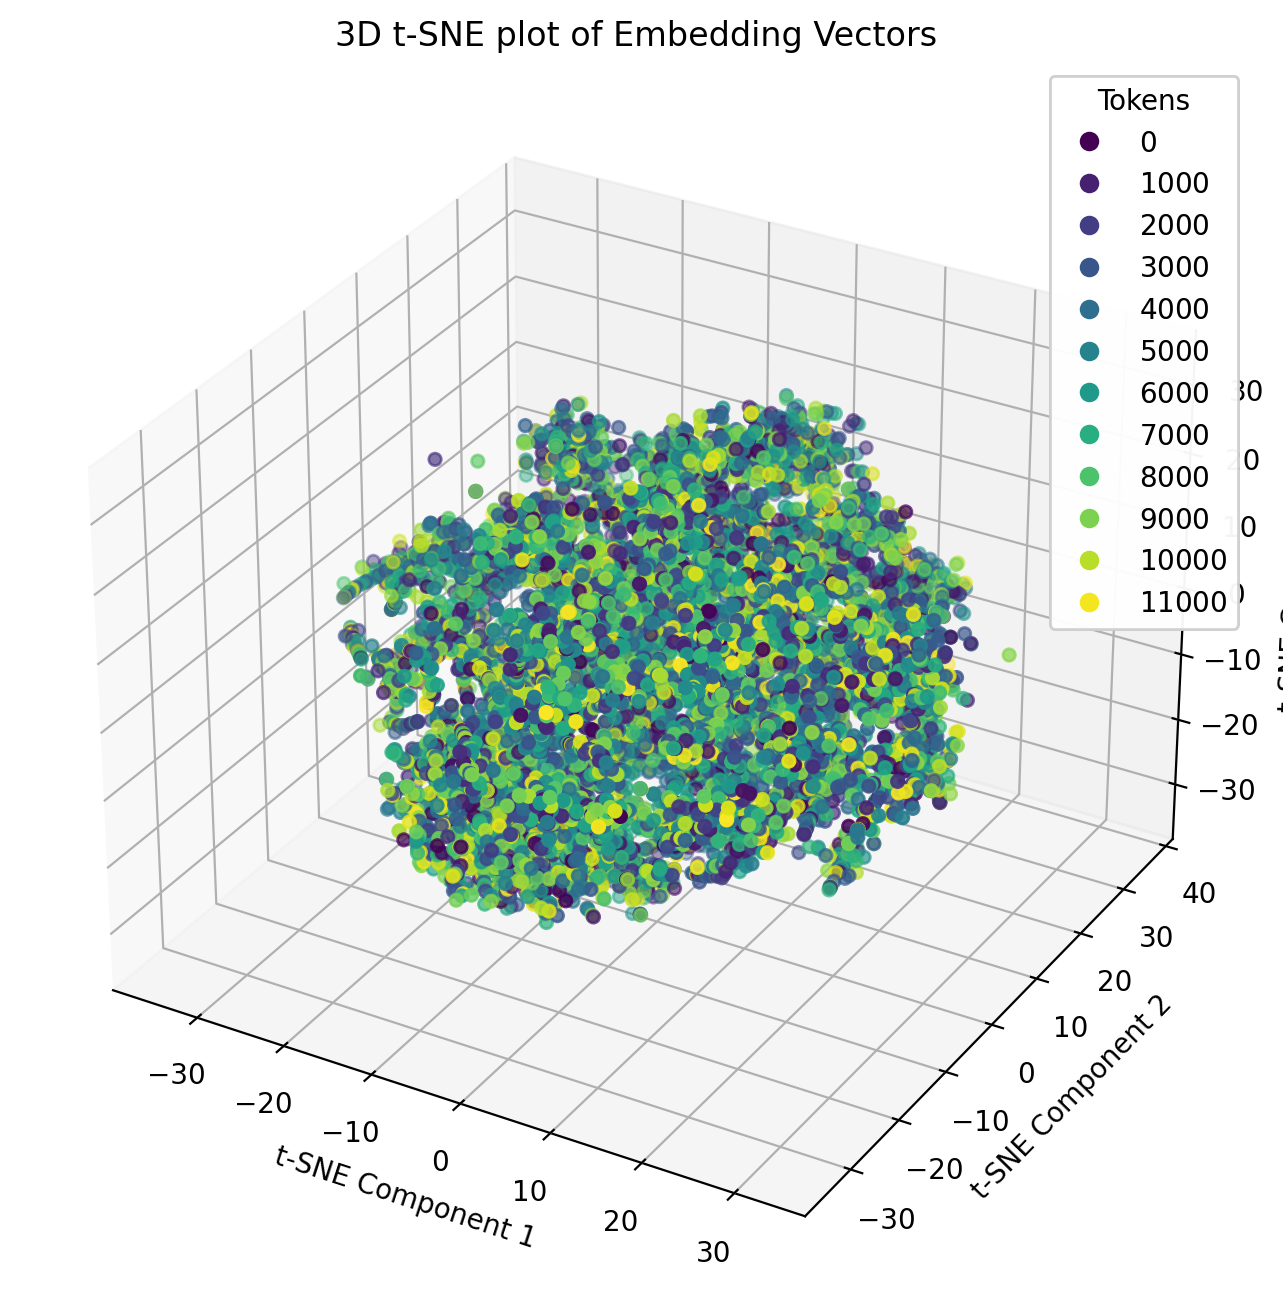

In [19]:
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


In [20]:
model_cpu = model.cpu()

torch.save(model_cpu.state_dict(), "model_5_32_512_t.pth")

In [21]:
model = model.to(device)

In [22]:
pd_itos_i = [i for s,i in stoi.items()]
pd_itos_s = [s for s,i in stoi.items()]

pd_itos = pd.DataFrame({"i":pd_itos_i, "s":pd_itos_s})
pd_stoi = pd.DataFrame({"s":pd_itos_s, "i":pd_itos_i})

pd_itos.to_csv('itos.csv')
pd_stoi.to_csv('stoi.csv')